In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, Resize, Compose, CenterCrop, ColorJitter, Normalize

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.fc1 = nn.Linear(32 * 28 * 28, 2048)
        self.fc2 = nn.Linear(2048, 312)
        self.fc3 = nn.Linear(312, 102)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, 32 * 28 * 28)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X

In [74]:
# Define a transform to resize the images and convert them to tensors
transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

# Load the dataset with the defined transform
dataset = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Function to calculate mean and std
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for (images, _) in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.4330, 0.3819, 0.2964])
Std: tensor([0.2555, 0.2056, 0.2175])


In [75]:
transform = Compose([
    Resize((128, 128)),  # Resize images to 256x256
    CenterCrop(112),      # Center crop to 224x224 (after resize)
    ToTensor(),           # Convert image to PyTorch tensor
    Normalize(mean=[0.4330, 0.3819, 0.2964],  # Normalize
                         std=[0.2555, 0.2056, 0.2175]),
    ColorJitter(brightness=0.1, contrast=0.1,  # Color Jitter - light
                           saturation=0.1, hue=0.1)
])


In [76]:
    train_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='train', download=True, transform=transform)
    val_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='val', download=True, transform=transform)
    test_data = datasets.Flowers102(root="/Users/maciek/cnn_data", split='test', download=True, transform=transform)

In [77]:
    train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=10, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [78]:
    model = ConvolutionalNetwork()

In [79]:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [80]:
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model = model.to(device)
    criterion = criterion.to(device)

In [81]:
    import time

    start_time = time.time()

    # Create Variables To Tracks Things
    epochs = 20
    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    # For Loop of Epochs
    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        # Train
        for b, (X_train, y_train) in enumerate(train_loader, 1):
            X_train, y_train = X_train.to(device), y_train.to(device)
            y_pred = model(X_train)  # get predicted values from the training set. Not flattened 2D
            loss = criterion(y_pred, y_train)  # how off are we? Compare the predictions to correct answers in y_train

            predicted = torch.max(y_pred.data, 1)[
                1]  # add up the number of correct predictions. Indexed off the first point
            batch_corr = (
                        predicted == y_train).sum()  # how many we got correct from this batch. True = 1, False=0, sum those up
            trn_corr += batch_corr  # keep track as we go along in training.

            # Update our parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print out some results
            if b % 10 == 0:
                print(f'Epoch: {i}  Batch: {b}  Loss: {loss.item()}')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # Test
        with torch.no_grad():  # No gradient so we don't update our weights and biases with test data
            for b, (X_test, y_test) in enumerate(val_loader):
                X_test, y_test = X_test.to(device), y_test.to(device)
                y_val = model(X_test)
                predicted = torch.max(y_val.data, 1)[1]  # Adding up correct predictions
                tst_corr += (predicted == y_test).sum()  # T=1 F=0 and sum away

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

    current_time = time.time()
    total = current_time - start_time
    print(f'Training Took: {total / 60} minutes!')

Epoch: 0  Batch: 10  Loss: 4.5239691734313965
Epoch: 0  Batch: 20  Loss: 4.746697902679443
Epoch: 0  Batch: 30  Loss: 4.671882629394531
Epoch: 0  Batch: 40  Loss: 4.648146629333496
Epoch: 0  Batch: 50  Loss: 4.6242218017578125
Epoch: 0  Batch: 60  Loss: 4.601174831390381
Epoch: 0  Batch: 70  Loss: 4.625540733337402
Epoch: 0  Batch: 80  Loss: 4.624518871307373
Epoch: 0  Batch: 90  Loss: 4.634274482727051
Epoch: 0  Batch: 100  Loss: 4.619232177734375
Epoch: 1  Batch: 10  Loss: 4.620085716247559
Epoch: 1  Batch: 20  Loss: 4.592809200286865
Epoch: 1  Batch: 30  Loss: 4.63347053527832
Epoch: 1  Batch: 40  Loss: 4.594542026519775
Epoch: 1  Batch: 50  Loss: 4.617873668670654
Epoch: 1  Batch: 60  Loss: 4.613368034362793
Epoch: 1  Batch: 70  Loss: 4.486451148986816
Epoch: 1  Batch: 80  Loss: 4.643640995025635
Epoch: 1  Batch: 90  Loss: 4.5550689697265625
Epoch: 1  Batch: 100  Loss: 4.490939140319824
Epoch: 2  Batch: 10  Loss: 4.420812129974365
Epoch: 2  Batch: 20  Loss: 4.462841987609863
Epoch:

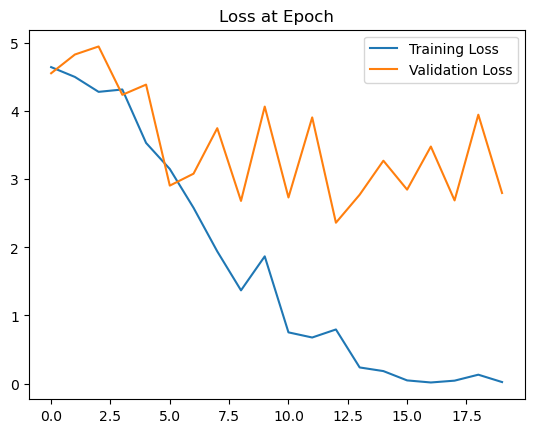

In [82]:
# Convert GPU tensors to CPU tensors, detach them from the computation graph, and then to NumPy arrays
train_losses = [tl.cpu().detach().numpy() for tl in train_losses]
test_losses = [tl.cpu().detach().numpy() for tl in test_losses]

# Now you can plot using matplotlib
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()
plt.show(block=True)

In [83]:
test_data

Dataset Flowers102
    Number of datapoints: 6149
    Root location: /Users/maciek/cnn_data
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(112, 112))
               ToTensor()
               Normalize(mean=[0.433, 0.3819, 0.2964], std=[0.2555, 0.2056, 0.2175])
               ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
           )

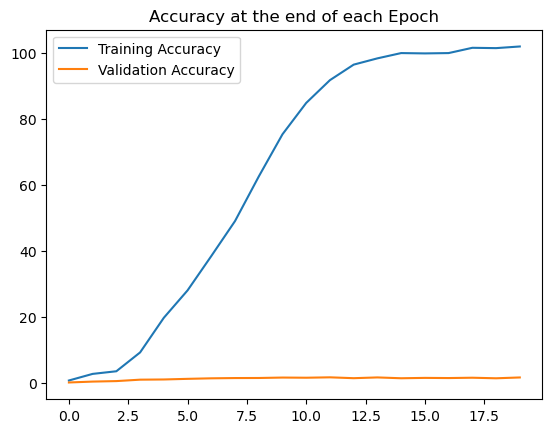

In [84]:
plt.plot([t.cpu()/10 for t in train_correct], label="Training Accuracy")
plt.plot([t.cpu()/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [85]:
test_load_everything = DataLoader(test_data, batch_size=6149, shuffle=False)

In [86]:
with torch.no_grad():
    correct = 0
    model.to('mps')  # Ensure the model is on the MPS device
    for X_test, y_test in test_load_everything:
        X_test = X_test.to('mps')  # Move X_test to MPS device
        y_test = y_test.to('mps')  # Move y_test to MPS device as well
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()


In [87]:
X_test.shape

torch.Size([6149, 3, 112, 112])

In [88]:
correct.item()/len(test_data)*100

13.693283460725322